✅ Using device: cuda


c:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 11.8MB/s]



Epoch [1/30]
Train Loss: 0.5951 | Acc: 0.7400
Val   Loss: 0.3219 | Acc: 0.9348

Epoch [2/30]
Train Loss: 0.4015 | Acc: 0.8775
Val   Loss: 0.3277 | Acc: 0.9565

Epoch [3/30]
Train Loss: 0.3356 | Acc: 0.9450
Val   Loss: 0.3374 | Acc: 0.9457

Epoch [4/30]
Train Loss: 0.3237 | Acc: 0.9300
Val   Loss: 0.3357 | Acc: 0.9674

Epoch [5/30]
Train Loss: 0.3459 | Acc: 0.9200
Val   Loss: 0.3293 | Acc: 0.9674

Epoch [6/30]
Train Loss: 0.3059 | Acc: 0.9625
Val   Loss: 0.3160 | Acc: 0.9783

Epoch [7/30]
Train Loss: 0.3024 | Acc: 0.9500
Val   Loss: 0.2993 | Acc: 0.9783

Epoch [8/30]
Train Loss: 0.2888 | Acc: 0.9700
Val   Loss: 0.3029 | Acc: 0.9674

Epoch [9/30]
Train Loss: 0.2733 | Acc: 0.9800
Val   Loss: 0.2955 | Acc: 0.9783

Epoch [10/30]
Train Loss: 0.3019 | Acc: 0.9525
Val   Loss: 0.2904 | Acc: 0.9674

Epoch [11/30]
Train Loss: 0.2955 | Acc: 0.9600
Val   Loss: 0.2784 | Acc: 0.9783

Epoch [12/30]
Train Loss: 0.2808 | Acc: 0.9650
Val   Loss: 0.2869 | Acc: 0.9783

Epoch [13/30]
Train Loss: 0.2859 | A

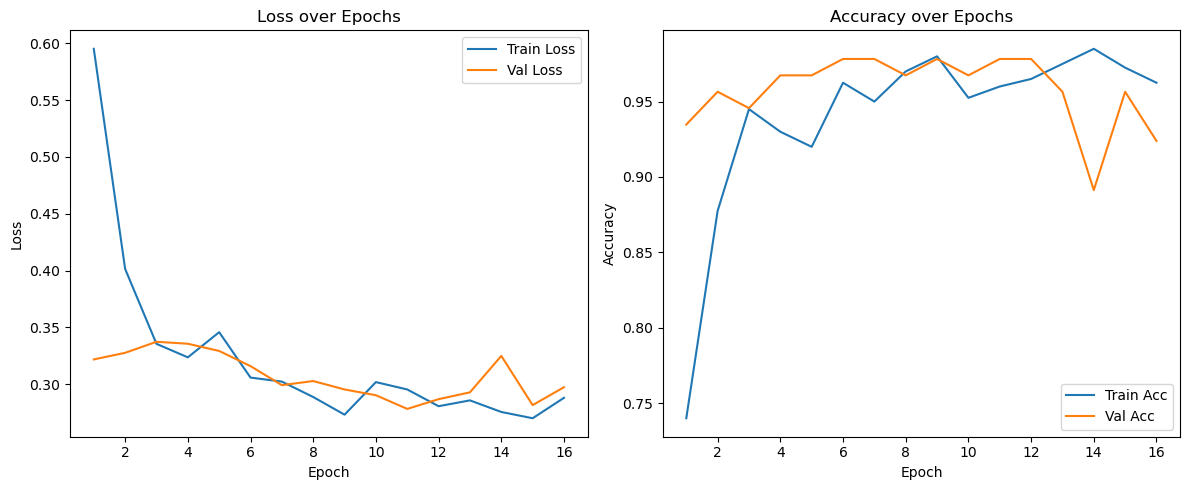

[📊 Test Evaluation]
              precision    recall  f1-score   support

         Cat       1.00      0.86      0.92         7
         Dog       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10

Confusion Matrix:
[[6 1]
 [0 3]]


In [25]:
import os
import random
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# ------------------ Data Setup ------------------
class ImageTransform:
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((resize, resize)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize((resize, resize)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

class DogVsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img, self.phase)
        label = 1 if 'dog' in os.path.basename(os.path.dirname(img_path)).lower() else 0
        return img, label

def load_data():
    cat_dir = './dogs-vs-cats/Cat'
    dog_dir = './dogs-vs-cats/Dog'
    cat_imgs = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
    dog_imgs = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
    all_imgs = [*cat_imgs, *dog_imgs]
    all_imgs = [f for f in all_imgs if cv2.imread(f) is not None]
    random.seed(42)
    random.shuffle(all_imgs)
    train = all_imgs[:400]
    val = all_imgs[400:-10]
    test = all_imgs[-10:]
    return train, val, test

# ------------------ Model + Training ------------------
def calculate_accuracy(y_pred, y_true):
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).sum().item() / y_true.size(0)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_acc += calculate_accuracy(out, y) * x.size(0)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            total_acc += calculate_accuracy(out, y) * x.size(0)
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def train_model(model, train_loader, val_loader, device,
                epochs=30, lr=5e-5, patience=5, min_delta=0.001):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Early Stopping
        if best_loss - val_loss > min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⛔ Early stopping triggered at epoch {epoch+1}")
                break

    return history

# ------------------ Evaluation ------------------
def plot_history(history):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title("Loss over Epochs")
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title("Accuracy over Epochs")
    plt.tight_layout()
    plt.show()

def evaluate_test(model, loader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            pred = torch.argmax(out, dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y.numpy())
    print("[📊 Test Evaluation]")
    print(classification_report(labels, preds, target_names=['Cat', 'Dog']))
    print("Confusion Matrix:")
    print(confusion_matrix(labels, preds))

# ------------------ Main ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

train_paths, val_paths, test_paths = load_data()
transform = ImageTransform(128, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_loader = DataLoader(DogVsCatDataset(train_paths, transform, 'train'), batch_size=8, shuffle=True)
val_loader = DataLoader(DogVsCatDataset(val_paths, transform, 'val'), batch_size=8, shuffle=False)
test_loader = DataLoader(DogVsCatDataset(test_paths, transform, 'val'), batch_size=1, shuffle=False)

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 2)
)
model = model.to(device)

# Train
history = train_model(model, train_loader, val_loader, device)
plot_history(history)
evaluate_test(model, test_loader, device)


---

c:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 | Time: 0m 2s
Train Loss: 0.6125, Acc: 0.7210
Val   Loss: 0.3401, Acc: 0.9222
Epoch 2 | Time: 0m 2s
Train Loss: 0.4188, Acc: 0.8840
Val   Loss: 0.3269, Acc: 0.9444
Epoch 3 | Time: 0m 2s
Train Loss: 0.3429, Acc: 0.9199
Val   Loss: 0.3096, Acc: 0.9556
Epoch 4 | Time: 0m 2s
Train Loss: 0.3441, Acc: 0.9199
Val   Loss: 0.2963, Acc: 0.9667
Epoch 5 | Time: 0m 2s
Train Loss: 0.3269, Acc: 0.9420
Val   Loss: 0.3091, Acc: 0.9556
Epoch 6 | Time: 0m 2s
Train Loss: 0.3369, Acc: 0.9227
Val   Loss: 0.2999, Acc: 0.9778
Epoch 7 | Time: 0m 2s
Train Loss: 0.3021, Acc: 0.9586
Val   Loss: 0.2971, Acc: 0.9667
Epoch 8 | Time: 0m 2s
Train Loss: 0.3171, Acc: 0.9641
Val   Loss: 0.3109, Acc: 0.9556
Epoch 9 | Time: 0m 2s
Train Loss: 0.3057, Acc: 0.9475
Val   Loss: 0.3193, Acc: 0.9556
Epoch 10 | Time: 0m 2s
Train Loss: 0.3215, Acc: 0.9392
Val   Loss: 0.3189, Acc: 0.9556
Epoch 11 | Time: 0m 2s
Train Loss: 0.3197, Acc: 0.9448
Val   Loss: 0.3025, Acc: 0.9778
Epoch 12 | Time: 0m 2s
Train Loss: 0.3274, Acc: 0.94

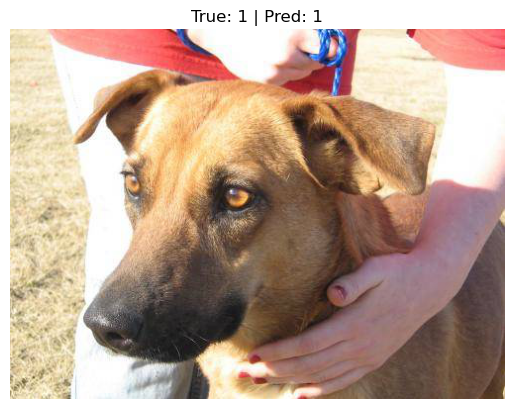

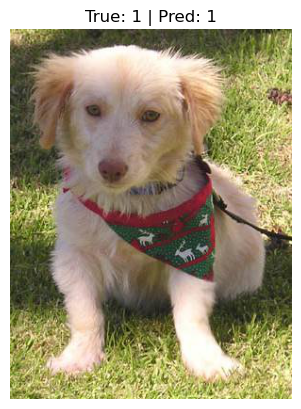

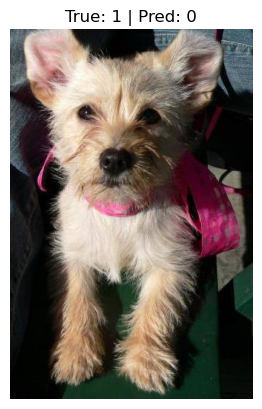

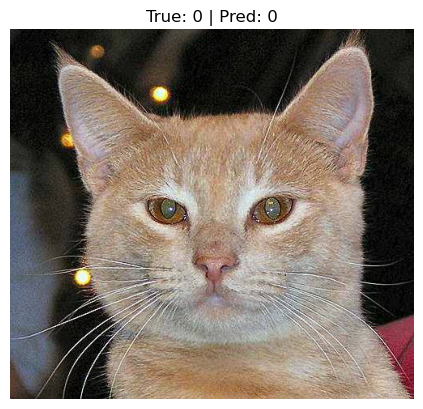

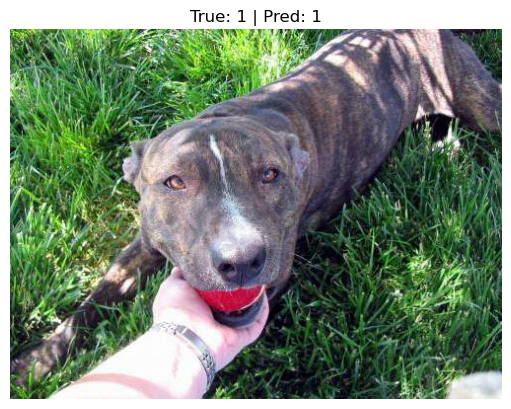

In [27]:
# ✅ PDF 기반 전체 구현 코드 (ResNet + SimpleNet + 학습 + 평가 + 시각화 + 저장)

import os
import random
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import time

# ------------------ 유틸 함수 ------------------
def epoch_time(start, end):
    elapsed = end - start
    mins = int(elapsed // 60)
    secs = int(elapsed % 60)
    return mins, secs

def calculate_topk_accuracy(y_pred, y_true, k=2):
    with torch.no_grad():
        batch_size = y_true.size(0)
        _, top_pred = y_pred.topk(k, dim=1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y_true.view(1, -1).expand_as(top_pred))
        acc_1 = correct[:1].reshape(-1).float().sum(0) / batch_size
        acc_k = correct[:k].reshape(-1).float().sum(0) / batch_size
    return acc_1.item(), acc_k.item()

# ------------------ 데이터 구성 ------------------
class ImageTransform:
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((resize, resize)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize((resize, resize)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

class DogVsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img, self.phase)
        label = 1 if 'dog' in os.path.basename(os.path.dirname(img_path)).lower() else 0
        return img, label, img_path

def load_data_fixed(max_total=502, test_ratio=0.1, val_ratio=0.2):
    cat_dir = './dogs-vs-cats/Cat'
    dog_dir = './dogs-vs-cats/Dog'
    cat_imgs = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
    dog_imgs = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
    all_imgs = [*cat_imgs, *dog_imgs]
    all_imgs = [f for f in all_imgs if cv2.imread(f) is not None][:max_total]
    random.seed(42)
    random.shuffle(all_imgs)

    n_test = int(max_total * test_ratio)
    n_val = int((max_total - n_test) * val_ratio)
    n_train = max_total - n_val - n_test
    return all_imgs[:n_train], all_imgs[n_train:n_train + n_val], all_imgs[n_train + n_val:]

# ------------------ 모델 ------------------
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 32 * 32, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ------------------ 학습 및 평가 ------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_acc += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y, _ in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            total_acc += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), total_acc / len(loader.dataset)

def evaluate_test(model, loader, device):
    model.eval()
    preds, labels, paths = [], [], []
    with torch.no_grad():
        for x, y, p in loader:
            x = x.to(device)
            out = model(x)
            pred = torch.argmax(out, dim=1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y.numpy())
            paths.extend(p)

    df = pd.DataFrame({"Image": paths, "Label": labels, "Predicted": preds})
    df.to_csv("predictions.csv", index=False)
    print("[📁 Saved] predictions.csv")
    print(classification_report(labels, preds))
    print(confusion_matrix(labels, preds))

    return df

def plot_predictions(df, n=5):
    samples = df.sample(n)
    for _, row in samples.iterrows():
        img = Image.open(row['Image']).convert("RGB")
        plt.imshow(img)
        plt.title(f"True: {row['Label']} | Pred: {row['Predicted']}")
        plt.axis('off')
        plt.show()

# ------------------ 실행 ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_paths, val_paths, test_paths = load_data_fixed()
transform = ImageTransform(128, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_loader = DataLoader(DogVsCatDataset(train_paths, transform, 'train'), batch_size=8, shuffle=True)
val_loader = DataLoader(DogVsCatDataset(val_paths, transform, 'val'), batch_size=8)
test_loader = DataLoader(DogVsCatDataset(test_paths, transform, 'val'), batch_size=1)

# model = SimpleNet().to(device)
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.fc.in_features, 2))
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

best_val_loss = float('inf')
for epoch in range(30):
    start = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    mins, secs = epoch_time(start, time.time())

    print(f"Epoch {epoch+1} | Time: {mins}m {secs}s")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_val_loss = val_loss

model.load_state_dict(torch.load('best_model.pt'))
df_results = evaluate_test(model, test_loader, device)
plot_predictions(df_results, n=5)
